In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj

dj.config["display.limit"] = 50
dj.config["enable_python_native_blobs"] = True

dj.config['nnfabrik.schema_name'] = "nnfabrik_v1_tuning"

import datajoint as dj
schema = dj.schema("nnfabrik_v1_tuning")

from nnfabrik.main import *
import nnfabrik

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from nnvision.tables.from_nnfabrik import TrainedModel, DataInfo

fetch_download_path = '/data/fetched_from_attach'

Connecting pawelp@134.2.168.16:3306


## MEI Activations

In [2]:
from nnvision.tables.main import Recording
from nnvision.tables.scores import TestCorrelationScore as TestCorrelationMonkey

from nndichromacy.tables.from_mei import MEISelector
from nndichromacy.tables.from_mei import TrainedEnsembleModel
from nndichromacy.tables.from_mei import MEIMethod
from nndichromacy.tables.from_mei import MEISeed
from nndichromacy.tables.from_mei import TrainedEnsembleModel
from nndichromacy.tables.scores import TestCorrelation as TestCorrelationMouse

from mei import mixins

In [3]:
@schema
class MEIMonkey(mixins.MEITemplateMixin, dj.Computed):
    """MEI table template.

    To create a functional "MEI" table, create a new class that inherits from this template and decorate it with your
    preferred Datajoint schema. Next assign your trained model (or trained ensemble model) and your selector table to
    the class variables called "trained_model_table" and "selector_table". By default, the created table will point to
    the "MEIMethod" table in the Datajoint schema called "nnfabrik.main". This behavior can be changed by overwriting
    the class attribute called "method_table".
    """

    trained_model_table = TrainedEnsembleModel
    selector_table = Recording.Units
    method_table = MEIMethod
    seed_table = MEISeed

In [14]:
mei_activations = (MEIMonkey() & dict(data_key='3631807112901')).fetch('score')

## Gabor Activations

In [5]:
import os
from os import listdir
from os.path import isfile, join

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.legacy.from_mei import TrainedEnsembleModel

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

In [73]:
def get_monkey_model(data_key):
    # loading model
    model_hash = 'f8bcd882c48a55dc6cd6d7afb656f1f9'
    ensemble_hash = 'e7a8d0b961ee37ffda0779bfed95f1cf'

    model_key = (TrainedModel * TrainedEnsembleModel.Member() & dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
    dataloaders, model = TrainedModel().load_model(model_key, include_dataloader=True)
    model.eval()

    # number of model neurons 
    n_units = model.readout[data_key].outdims

    # image dimensions
    w, h = 41, 41
    
    return model, n_units, w, h, data_key, dataloaders

data_key='3631807112901'

model, n_units, w, h, data_key, dataloaders = get_monkey_model(data_key=data_key)

In [109]:
# Finite Set
canvas_size         = [w, h]
sizes               = FiniteParameter([float(val) for val in range(5, 31)][::5])
spatial_frequencies = FiniteParameter([float(val) for val in np.linspace(1/80, 2/5, 12)])
contrasts           = FiniteParameter([.5])
orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 12)])
phases              = FiniteParameter([float(val) for val in np.linspace(0.0, 2*np.pi, 12)]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([float(val) for val in np.linspace(0.0, 0.99, 5)])
locations           = FiniteParameter([[float(x), float(y)] for x in range(12, 28) 
                                                            for y in range(12, 28)][::16])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

In [110]:
best_params, values = gabor_set.find_optimal_stimulus_bruteforce(model=model, data_key=data_key, batch_size=1000)

830it [14:07,  1.02s/it]                         


In [111]:
gabor_activations = values

In [112]:
class GaussianLR(object):
    def __init__(self):
        self.w = 0
        self.sigma = 0
  
    def fit(self, x_train, y_train):
        N = x_train.shape[0]

        self.w = y_train @ x_train / (x_train @ x_train)

        self.sigma = np.power(x_train * self.w - y_train, 2).sum() / N
        self.sigma **= .5
        
    def predict(self, x):
        mean = self.w * x
        return mean, self.sigma
    
    def __repr__(self):
        return f"N({self.w:.2f}x, {self.sigma:.2f})"
    
    def __str__(self):
        return f"$N(\mu = {self.w:.2f}x, \sigma = {self.sigma:.2f})$"

In [113]:
lr = GaussianLR()
lr.fit(mei_activations, gabor_activations)
lr_mean, lr_sigma = lr.predict(np.arange(0, 14))
lr

N(0.64x, 0.70)

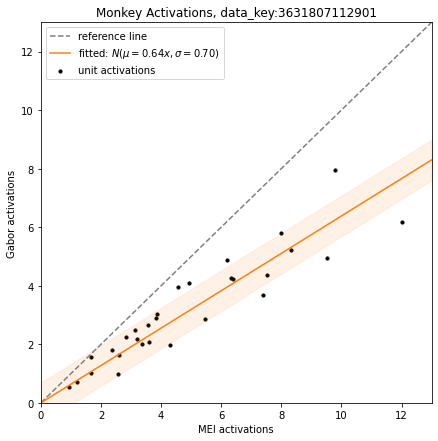

In [114]:
plt.figure(figsize=(7, 7))
plt.scatter(mei_activations, gabor_activations, s=10, c='k', label='unit activations')

plt.plot([0, 13], [0, 13], c='tab:gray', ls='--', label='reference line')

plt.plot(np.arange(0, 14), lr_mean, c='tab:orange', label=f'fitted: {lr}')
plt.fill_between(np.arange(0, 14), lr_mean + lr_sigma, lr_mean - lr_sigma, alpha=0.1, color='tab:orange')

plt.xlim(0, 13)
plt.ylim(0, 13)

plt.xlabel('MEI activations')
plt.ylabel('Gabor activations')

plt.title(f'Monkey Activations, data_key:{data_key}')

plt.legend()

plt.show()

The fit is 
\begin{equation}
    A_{gabor} = 0.63 A_{mei}
\end{equation}
thus the MEIs activate the neurons stronger than the found gabors.
\begin{equation}
    \frac{A_{mei}}{A_{gabor}} = 1.6
\end{equation}